# Week 9 Practical - Question 1 Solution

Select one of the previous face datasets that we have used (YaleB, ORL or Yale) and the method of your choice for extracting a face representation (i.e. PCA, LDA or a Siamese Network). Using these:
1. Transform the input faces from the dataset of your choice, using the method of your choice;
2. Cluster the resultant embeddings using:
  * K-Means
  * A GMM
  * HAC
  * DBScan
3.  For each method, choose appropriate hyper-parameters. Use prior knowledge (i.e. the number of true faces in the dataset, a typical distance between two faces) to aid your parameter select.
4.  Compute the purity, completeness and v-measure for each clustering method.

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import pandas
import numpy
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from datetime import datetime
import scipy.io
import random
from sklearn.manifold import TSNE

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

## Part 1. Our Transform

We'll use a Siamese network. This is all taken straight from the week 7 prac solution via the magic that is copy-paste.

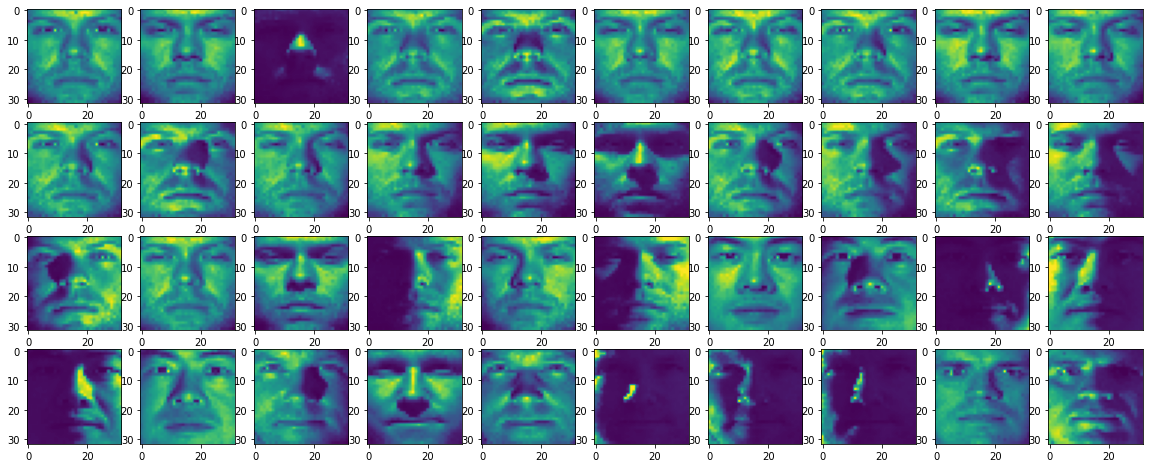

In [2]:
yale_b = scipy.io.loadmat('../../data/YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]
train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])    

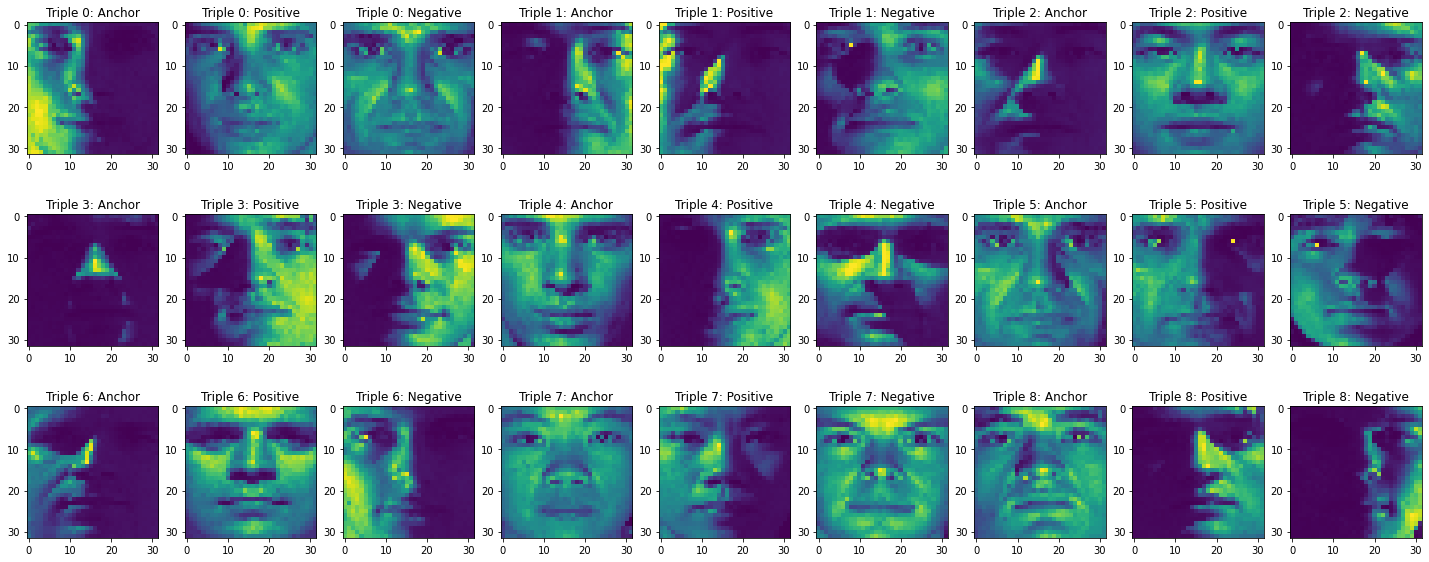

In [3]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def GetTripletData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

def TripleGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = GetTripletData(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None
        
test = TripleGenerator(train_fea_reshape, train_gnd, 9)
x, _ = next(test)

fig = plt.figure(figsize=[25, 10])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Triple ' + str(i) + ': Anchor')
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Positive')

    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Negative')        

In [4]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

embedding_size = 32
dummy_input = keras.Input((32, 32, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
input_anchor = keras.Input((32, 32, 1), name='Anchor')
input_positive = keras.Input((32, 32, 1), name='Positive')
input_negative = keras.Input((32, 32, 1), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])

triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
triplet_network.summary()

triplet_network.compile(optimizer=keras.optimizers.RMSprop())

batch_size = 128
training_gen = TripleGenerator(train_fea_reshape, train_gnd, batch_size)
triplet_test_x = GetTripletData(test_fea_reshape, test_gnd, 1000)

triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=10, validation_data=(triplet_test_x, None))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor (InputLayer)             [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
Positive (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
Negative (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
SiameseBranch (Functional)      (None, 32)           552056      Anchor[0][0]                     
                                                                 Positive[0][0]               

### Part 1b. Transform our data

We now need to use the Siamese network to map our data to the embedding space. Let's do that.

In [5]:
embeddings = base_network.predict(test_fea_reshape)

## Part 2. Clustering

We can now get into the clustering. In each case, we'll create a function to allow for easy re-use. We'll also create a couple of helper functions to measure our clustering accuracy, and to plot some things.

In [6]:
def eval(gt, pred):
    purity = homogeneity_score(gt, pred)
    completeness = completeness_score(gt, pred)
    vmeasure = v_measure_score(gt, pred)

    print('Purity: %0.3f, Completeness: %0.3f, V-Measure: %0.3f' % (purity, completeness, vmeasure))
    
    return purity, completeness, vmeasure

def plot(data, true_labels, predicted_labels):

    fig = plt.figure(figsize=[20, 8])
    ax = fig.add_subplot(1, 2, 1)
    tsne_embeddings = TSNE(random_state=4).fit_transform(data)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = true_labels)
    ax.set_title('Ground Truth')
    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = predicted_labels)
    ax.set_title('Clustered')

### K-Means

We have some good prior info here, in that we know there are 38 subjects in the data.

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Purity: 0.986, Completeness: 0.987, V-Measure: 0.987


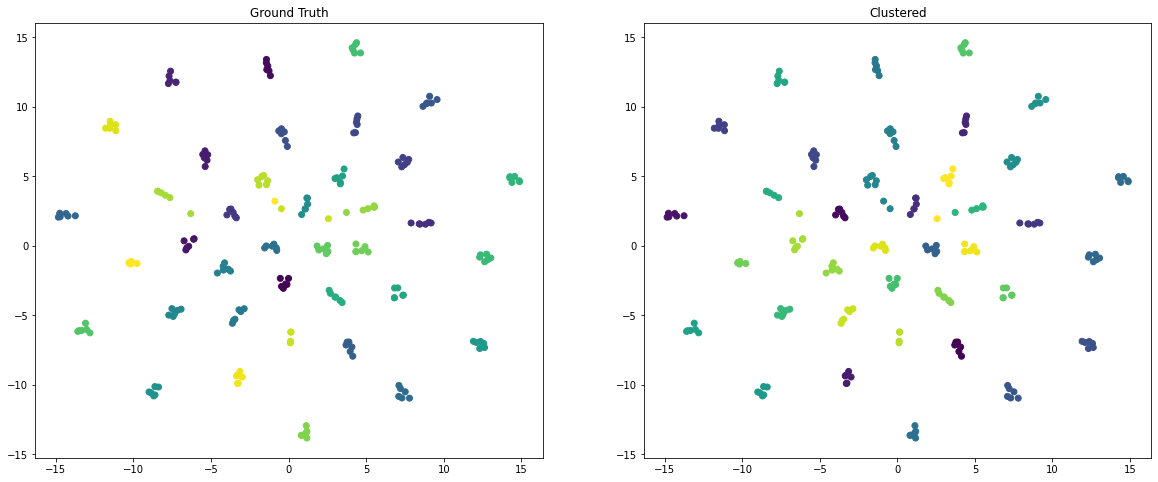

In [7]:
def kmeans_eval(k, seed, data, labels):
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(data)
    
    plot(data, labels, kmeans.labels_)    
    eval(labels, kmeans.labels_)

kmeans_eval(38, 4, embeddings, test_gnd)

### GMM

Same approach for a GMM now, again, we have prior knowledge about the number of true clusters, so we'll use that.

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Purity: 0.989, Completeness: 0.990, V-Measure: 0.990


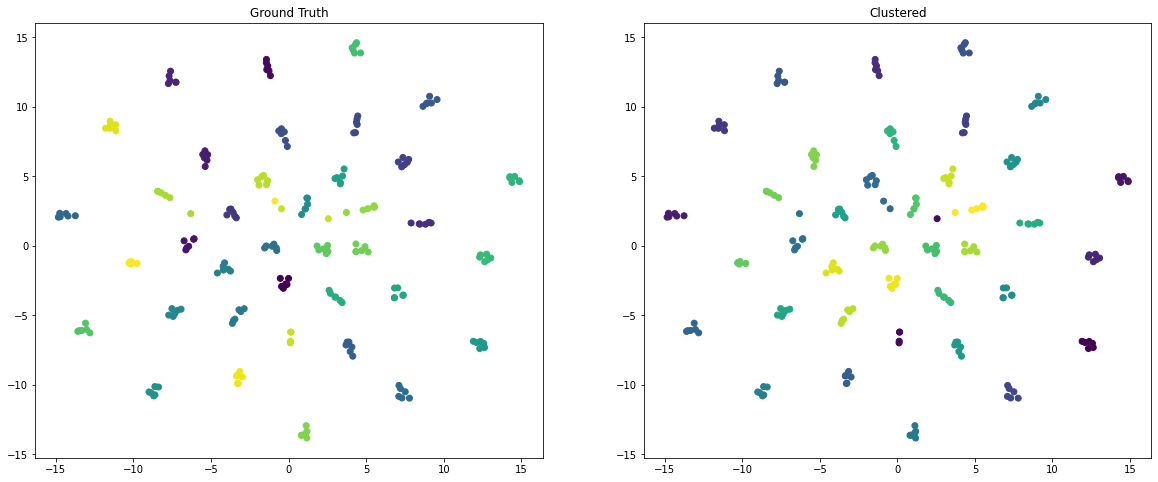

In [8]:
def gmm_eval(k, seed, data, labels):
    gmm = GaussianMixture(n_components=k, random_state=seed).fit(data)
    pred_labels = gmm.predict(data)

    plot(data, labels, pred_labels)    
    eval(labels, pred_labels)

gmm_eval(38, 4, embeddings, test_gnd)

### HAC

We can approach HAC in one of two ways, either we can use the number of true clusters to constrain our tracking, or we can use a distance measure.

For the second, we need to first work out how far apart two faces might be. We can do that with the training data and meaure how far two faces belonging to the same subject, and two faces belonging to a different subject, are from each other.

Text(0.5, 1.0, 'Distance Between Embeddings in Different Clusters')

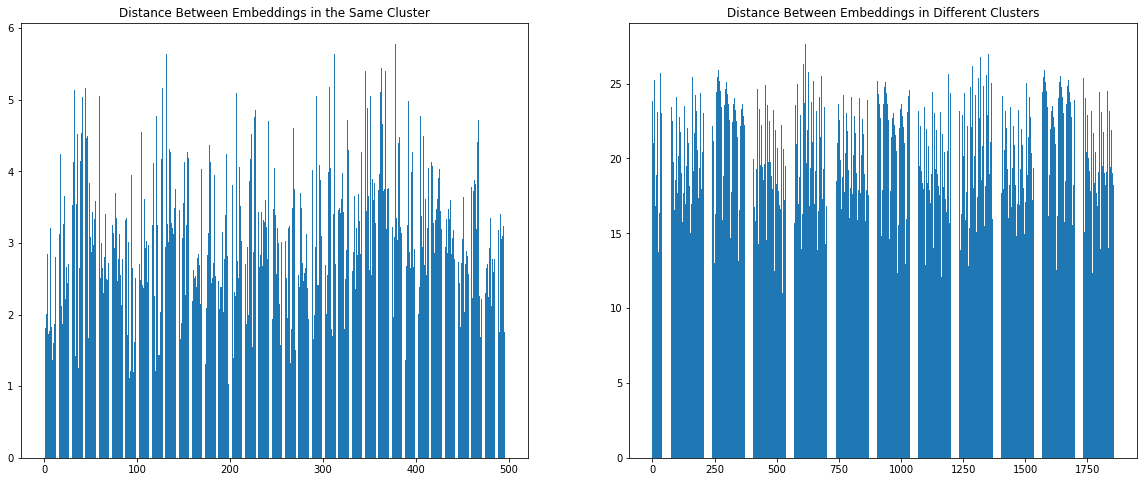

In [9]:
embeddings_train = base_network.predict(train_fea_reshape)
embeddings_subject_1 = embeddings_train[train_gnd == 1, :]
embeddings_subject_2 = embeddings_train[train_gnd == 2, :]

dists_within = []
for i in range(numpy.shape(embeddings_subject_1)[0]):
    for j in range(i+1, numpy.shape(embeddings_subject_1)[1]):
        dists_within.append(numpy.linalg.norm(embeddings_subject_1[i, :] - embeddings_subject_1[j, :]))

dists_between = []
for i in range(numpy.shape(embeddings_subject_1)[0]):
    for j in range(numpy.shape(embeddings_subject_2)[1]):
        dists_between.append(numpy.linalg.norm(embeddings_subject_1[i, :] - embeddings_subject_2[j, :]))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 2, 1)
ax.bar(range(len(dists_within)), dists_within)
ax.set_title('Distance Between Embeddings in the Same Cluster')
ax = fig.add_subplot(1, 2, 2)
ax.bar(range(len(dists_between)), dists_between)
ax.set_title('Distance Between Embeddings in Different Clusters')

From the above, we can see in both cases some faces that are very close to each other - chances are we can't do anything about those, and these are probably caused by weird lighting.

In general though, faces that belong to the same person are rarely more than a distance of 5 from each other, and faces that belong to different people are rarely closer than a distance of 10. With that in mind, we can pick a distance measure.

Note that our HAC function is setup to take either K or the distance measure.

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Purity: 0.972, Completeness: 0.981, V-Measure: 0.976


/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Purity: 1.000, Completeness: 0.789, V-Measure: 0.882


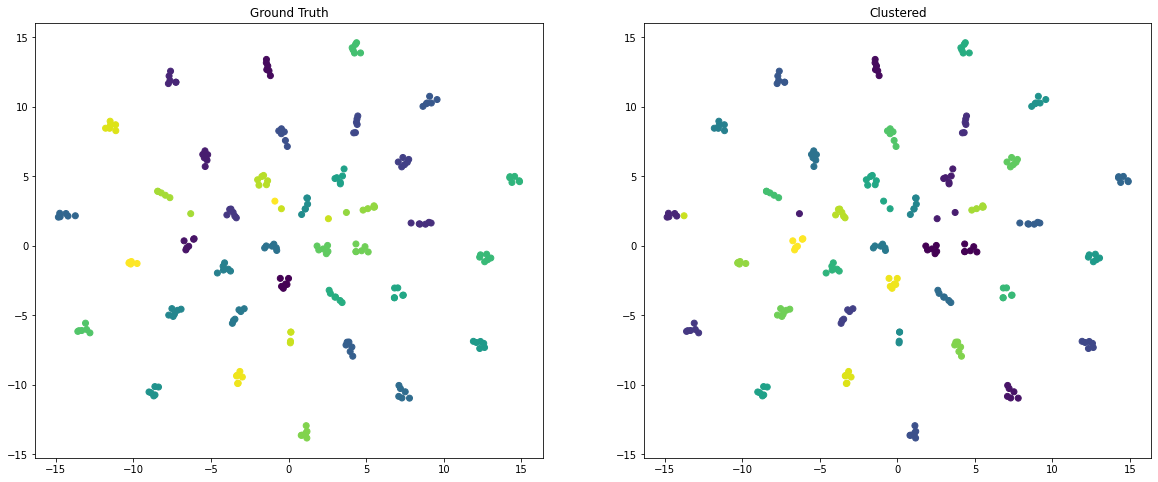

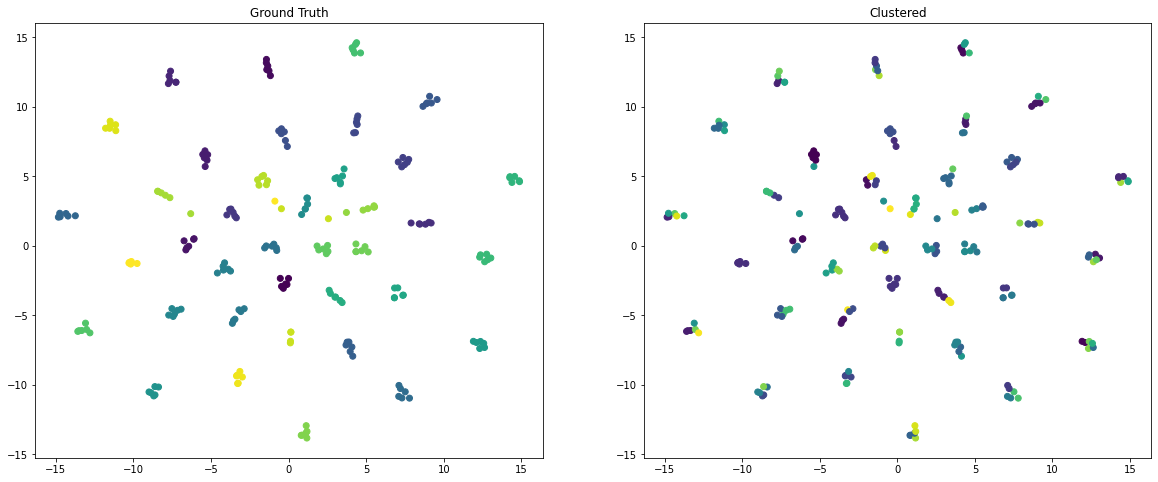

In [10]:
def hac_eval(data, labels, k = None, distance_threshold = None):
    hac = AgglomerativeClustering(n_clusters=k, distance_threshold=distance_threshold, linkage='complete').fit(data)

    plot(data, labels, hac.labels_)        
    eval(labels, hac.labels_)

hac_eval(embeddings, test_gnd, 38, None)
hac_eval(embeddings, test_gnd, None, 5)

### DBScan

DBScan is last. We can use the distance plots that we computed above to help inform our hyper-parameters here.

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Purity: 0.687, Completeness: 0.950, V-Measure: 0.797


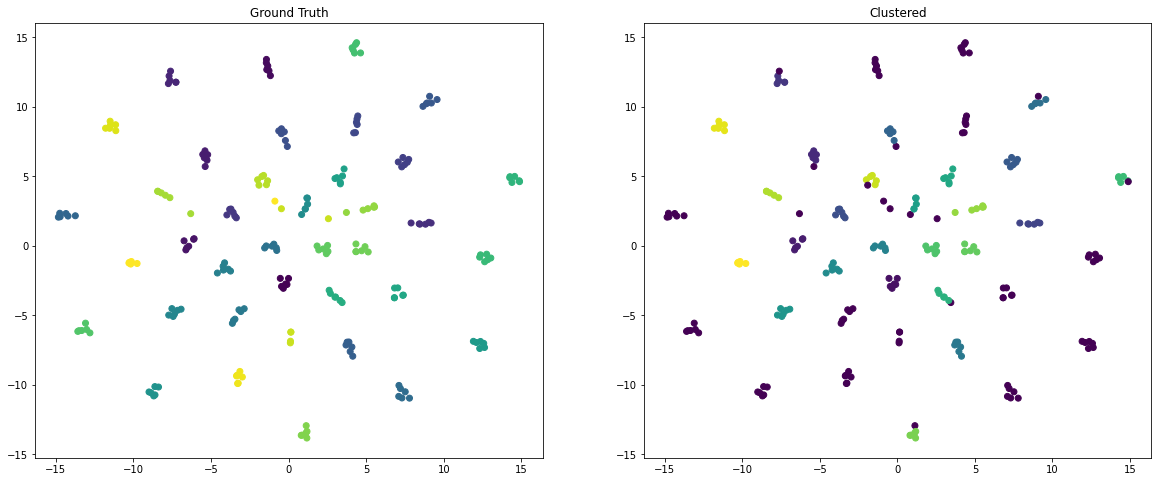

In [12]:
def dbscan_eval(eps, min_k, data, labels):
    
    dbscan = DBSCAN(eps=eps, min_samples=min_k).fit(data)
    
    plot(data, labels, dbscan.labels_)        
    eval(labels, dbscan.labels_)
    
dbscan_eval(5, 5, embeddings, test_gnd)

### Observations

From the above we see that:
* K-Means, the GMM and HAC with the number of clusters set all do very well. K-means even get's it all perfectly correct. We are helped greatly here by:
  * Knowing the true number of clusters
  * Having our encoder trained on data that's well aligned with what we're trying to cluster (i.e. train and test splits of the same dataset)
* HAC (with the distance measure) and DBScan still do well, but not as well - in large part becuase the hyper-parameters are harder to set.

## ORL Dataset

Because we can, let's run this through the Yale dataset now.

In [15]:
orl = scipy.io.loadmat('../../data/ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

gnd = numpy.reshape(gnd, -1)
fea = numpy.reshape(fea.transpose(), (32, 32, 1, len(fea)))
fea = numpy.transpose(fea, (3, 1, 0, 2))

embeddings = base_network.predict(fea)

### K-Means

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Purity: 0.642, Completeness: 0.666, V-Measure: 0.654


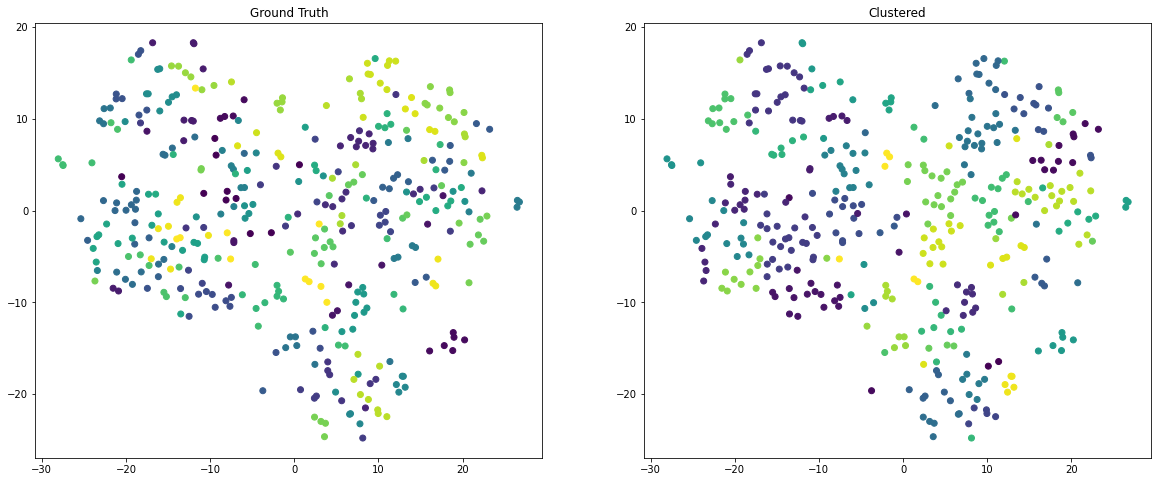

In [16]:
kmeans_eval(40, 4, embeddings, gnd)

### GMM

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Purity: 0.617, Completeness: 0.641, V-Measure: 0.629


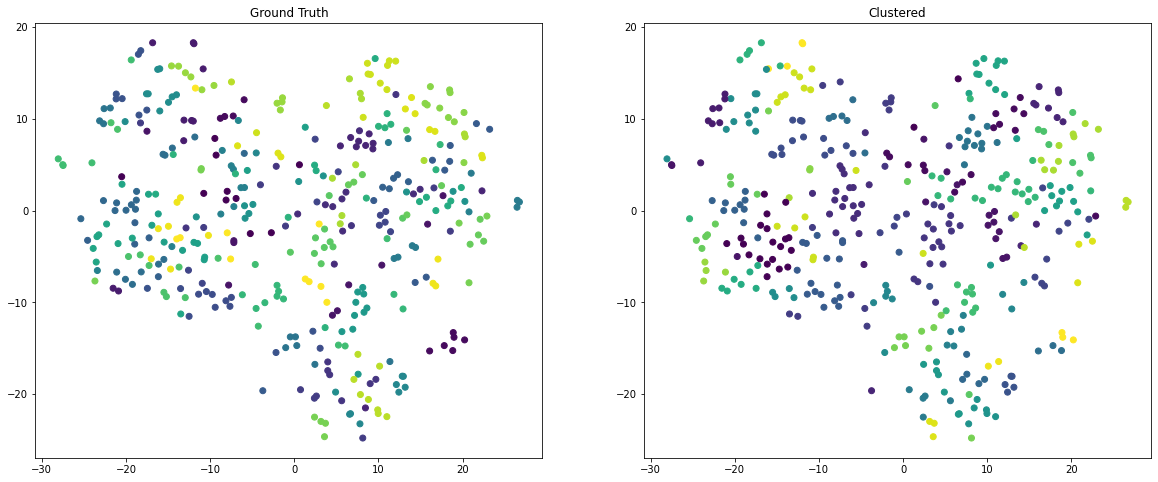

In [17]:
gmm_eval(40, 4, embeddings, gnd)

### HAC

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Purity: 0.616, Completeness: 0.654, V-Measure: 0.635


/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Purity: 0.926, Completeness: 0.658, V-Measure: 0.769


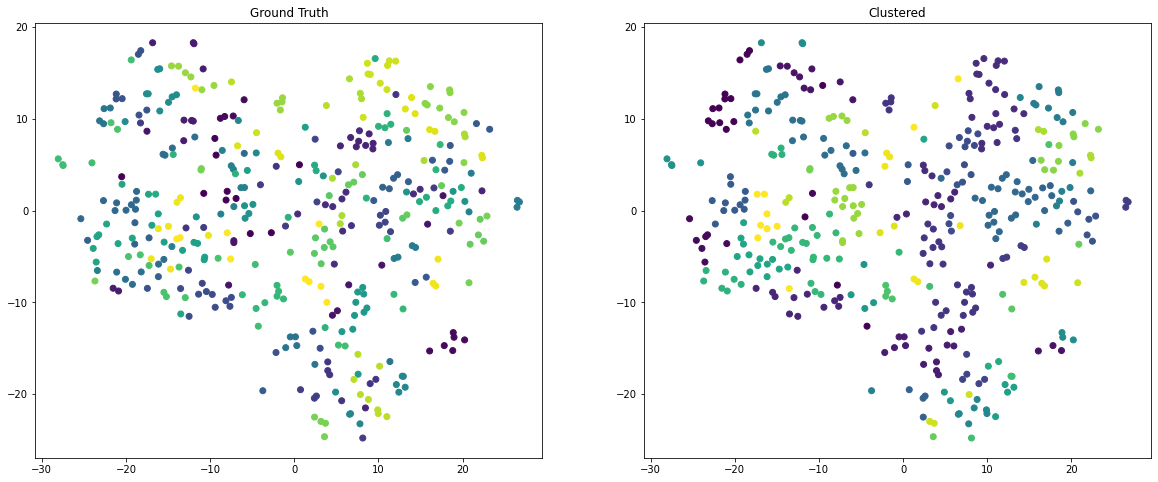

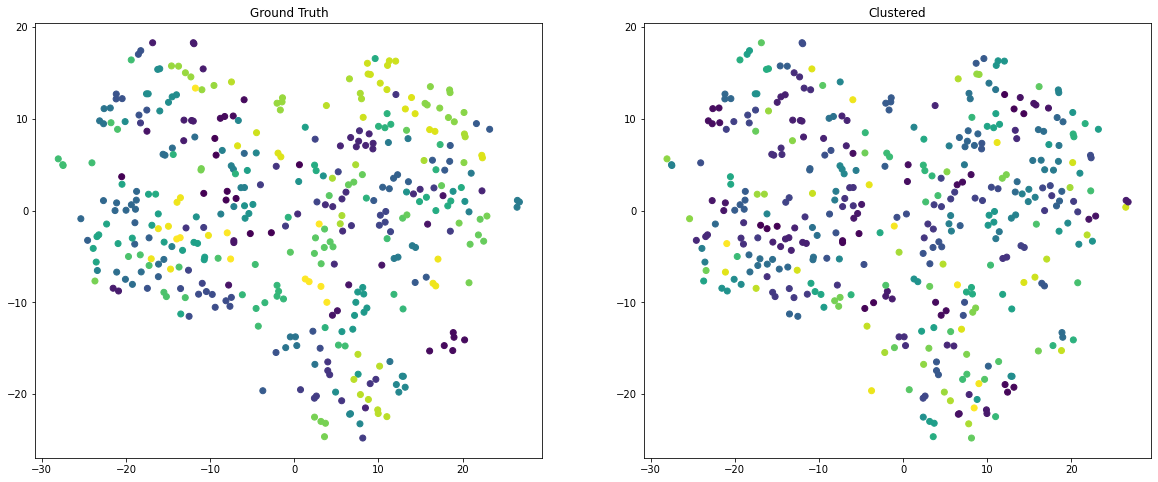

In [18]:
hac_eval(embeddings, gnd, 40, None)
hac_eval(embeddings, gnd, None, 5)

### DBScan

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Purity: 0.088, Completeness: 0.480, V-Measure: 0.148


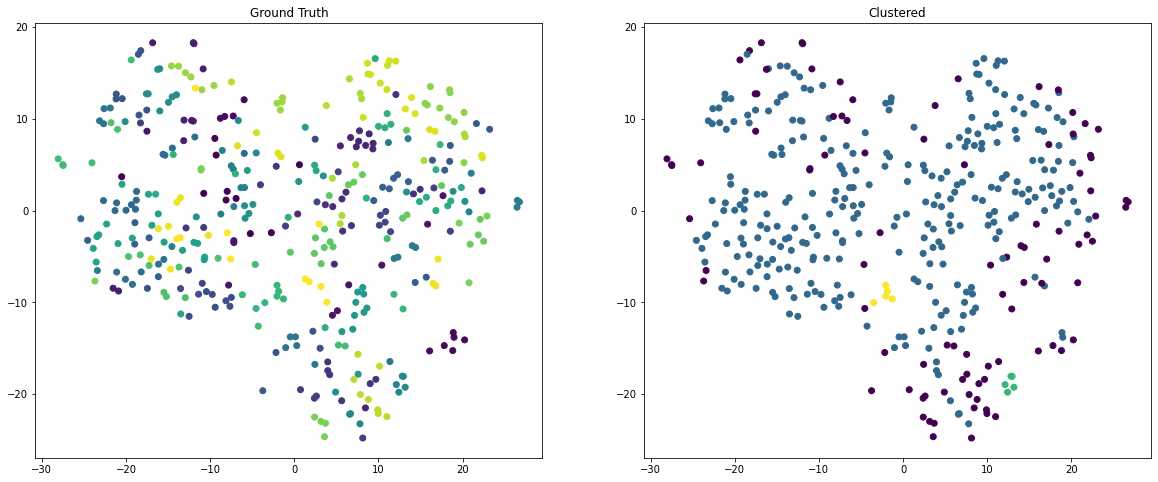

In [19]:
dbscan_eval(5, 5, embeddings, gnd)

### Thoughts

It's fair to say that on the whole, this is less effective. Our embeddings are not doing as good a job on this data, and this bleeds into our clustering results.

## Things to try

This solution will end here, but there are a number of things that you are encouraged to try, including:
* Run this on the Yale dataset, and see what happens
* Try to optimise the distance based hyper-parameters for HAC and DBScan for all datasets
* Explore different linkage criteria within HAC
* Explore how purity and completeness trade-off against one another as you change clustering parameters
* Switch out the DCNN for PCA, or LDA (or PCA + LDA)